Reference: https://pennylane.ai/qml/demos/tutorial_classical_expval_estimation  

## Our target: 양자 회로의 기댓값 추정(Estimating)  
We are familiar with this simple equation  
$$E(\theta) = \langle \psi_0 | U^{\dagger}(\theta) H U(\theta) | \psi_o \rangle$$
앞으로 초기 상태는 ground-state로 줄 것. and we will work with a particular example for the circuit $U(\theta)$ and discuss the class of parametrized circuits the algorithms can tackle further below.  

회로는 Hardware-efficient ansatz로 구성할 것이고, 관측자는 다음과 같이 파울리 가족으로 분해 가능  
$$H = \sum_{l=1}^{L} {h_l P_l}, \quad P_l \in \{I, X, Y, Z\}^{\otimes N}$$
여기서 The number of qubits on which a Pauli word is supported(i.e., has a non-identity component)를 weight라고 하며, 이 weights에 특정 threshold를 정할 것임. 아래의 truncation step을 보셈. For our example, we pick the Heisenberg model Hamiltonian  
$$H_{XYZ} = \sum_{j=1}^{N-1}{(h_j^{(X)}X_j X_{j+1} + h_j^{(Y)}Y_j Y_{j+1} + h_j^{(Z)}Z_j Z_{j+1})}$$
with random coefficients $h_j^{(X|Y|Z)}$. In $H_{XYZ}$, 위 해밀토니안의 각 항을 보면 Pauli word가 2개씩이므로 모두 weight two  

아래서 회로 구현할건데, CNOT은 ring으로 줄 것. 그리고 ```ansatz``` function을 ```make_tape()```으로 변형할 것임, ,making the funciton into one that returns a tape containing the gates (and expectation value). 참고로 ansatz 그리기도 현해짐

In [2]:
import cudaq
# 현재 시스템에서 인식 가능한 모든 타겟 출력
for target in cudaq.get_targets():
    print(target)

Target tensornet-mps
	simulator=tensornet_mps
	platform=default
	description=cutensornet simulator backend target based on matrix product state representation
	precision=fp64
Supported Arguments:
  - option (Specify the target options as a comma-separated list.
Supported options are 'fp32', 'fp64')

Target stim
	simulator=stim
	platform=default
	description=Stim-based CPU-only backend target
	precision=fp64

Target quera
	simulator=qpp
	platform=default
	description=CUDA-Q target for QuEra.
	precision=fp32
Supported Arguments:
  - machine (Specify the QuEra QPU.)
  - default_bucket (Specify a default S3 bucket for QuEra results.)

Target quantum_machines
	simulator=qpp
	platform=default
	description=CUDA-Q target for Quantum Machines.
	precision=fp32
Supported Arguments:
  - url (Specify Quantum Machine base server url.)
  - executor (Specify the executor to run. Default is mock)
  - api_key (An API key to access the Qoperator server)

Target pasqal
	simulator=qpp
	platform=default
	de

In [10]:
import pennylane as qml
import numpy as np
from itertools import combinations, product

def _ansatz(params_set, num_qubits, H):
    for i, params in enumerate(params_set):
        for j, rot_params in enumerate(params):
            qml.RZ(rot_params[0], j)
            qml.RZ(rot_params[1], j)
            qml.RZ(rot_params[2], j)
        if i < len(params) -1 :
            for j in range(num_qubits):
                qml.CNOT([j, (j+1)%num_qubits])

    return qml.expval(H)

ansatz = qml.transforms.make_tape(_ansatz)

num_qubits = 4
num_layers = 3
np.random.seed(423)

H_coeffs = np.random.random((num_qubits-1)*3)
H_ops = [op(j) @ op(j+1) for j in range(num_qubits-1) for op in [qml.X, qml.Y, qml.Z]]
H = qml.dot(H_coeffs, H_ops)

params = np.random.random((num_layers, num_qubits, 3))
tape = ansatz(params, num_qubits, H)
print(qml.drawer.tape_text(tape))

0: ──RZ──RZ──RZ─╭●───────╭X──RZ──RZ──RZ─╭●───────╭X──RZ──RZ──RZ─┤ ╭<𝓗>
1: ──RZ──RZ──RZ─╰X─╭●────│───RZ──RZ──RZ─╰X─╭●────│───RZ──RZ──RZ─┤ ├<𝓗>
2: ──RZ──RZ──RZ────╰X─╭●─│───RZ──RZ──RZ────╰X─╭●─│───RZ──RZ──RZ─┤ ├<𝓗>
3: ──RZ──RZ──RZ───────╰X─╰●──RZ──RZ──RZ───────╰X─╰●──RZ──RZ──RZ─┤ ╰<𝓗>


## Pauli propagation  
표준 시뮬레이션은 state vector 시뮬이고, 얘는 상태 벡터를 각 게이트를 적용해서 변화시킴.From a physics perspective, this is the evolution of a quantum state in the Schrodinger picture. 시뮬을 종료하려면 상태를 마지막에 observable $H$로 수축시켜야 함  

여기서는 이제 Heisenberg picture를 사용할 것임. 이는 상태가 아닌, 측정 관측자의 진화를 다루는 관점임. This technique is called *Pauli propagation* 

Heisenberg picture에서 각 게이트 $V$는 관측자에 다음과 같이 적용됨
$$H^{'} = V^{\dagger}HV$$
이렇게 진화된 관측자는 시뮬레이션의 맨 마지막에 초기 상태를 만나 contracted됨  

Pauli propagation은 해밀토니안 속의 Pauli words $P_l$을 추적함, requiring us to only determine how a gate $V$ acts on any Pauli word. 클리포드 게이트는 정의에 따라 어떠한 pauli word에 의해 다른 pauli word로 매핑되는데, 예시는 다음과 같음
$$CNOT(Z\otimes Z)CNOT = I\otimes Z$$

In [14]:
cnot = qml.CNOT([0,1])

for op0, op1 in product([qml.I, qml.X, qml.Y, qml.Z], repeat = 2):
    original_op = op0(0) @ op1(1)
    new_op = cnot @ original_op @ cnot
    new_op = qml.pauli_decompose(new_op.matrix())
    print(f"CNOT transforms {original_op} to {new_op}")

CNOT transforms I(0) @ I(1) to 1.0 * (I(0) @ I(1))
CNOT transforms I(0) @ X(1) to 1.0 * (I(0) @ X(1))
CNOT transforms I(0) @ Y(1) to 1.0 * (Z(0) @ Y(1))
CNOT transforms I(0) @ Z(1) to 1.0 * (Z(0) @ Z(1))
CNOT transforms X(0) @ I(1) to 1.0 * (X(0) @ X(1))
CNOT transforms X(0) @ X(1) to 1.0 * (X(0) @ I(1))
CNOT transforms X(0) @ Y(1) to 1.0 * (Y(0) @ Z(1))
CNOT transforms X(0) @ Z(1) to -1.0 * (Y(0) @ Y(1))
CNOT transforms Y(0) @ I(1) to 1.0 * (Y(0) @ X(1))
CNOT transforms Y(0) @ X(1) to 1.0 * (Y(0) @ I(1))
CNOT transforms Y(0) @ Y(1) to -1.0 * (X(0) @ Z(1))
CNOT transforms Y(0) @ Z(1) to 1.0 * (X(0) @ Y(1))
CNOT transforms Z(0) @ I(1) to 1.0 * (Z(0) @ I(1))
CNOT transforms Z(0) @ X(1) to 1.0 * (Z(0) @ X(1))
CNOT transforms Z(0) @ Y(1) to 1.0 * (I(0) @ Y(1))
CNOT transforms Z(0) @ Z(1) to 1.0 * (I(0) @ Z(1))


We will use these results as a lookup table for the simulation below, so let's store them in a string-based dictionary:

In [26]:
cnot_table = {
    ("I", "I"): (("I", "I"), 1),
    ("I", "X"): (("I", "X"), 1),
    ("I", "Y"): (("Z", "Y"), 1),
    ("I", "Z"): (("Z", "Z"), 1),
    ("X", "I"): (("X", "X"), 1),
    ("X", "X"): (("X", "I"), 1),
    ("X", "Y"): (("Y", "Z"), 1),
    ("X", "Z"): (("Y", "Y"), -1),
    ("Y", "I"): (("Y", "X"), 1),
    ("Y", "X"): (("Y", "I"), 1),
    ("Y", "Y"): (("X", "Z"), -1),
    ("Y", "Z"): (("X", "Y"), 1),
    ("Z", "I"): (("Z", "I"), 1),
    ("Z", "X"): (("Z", "X"), 1),
    ("Z", "Y"): (("I", "Y"), 1),
    ("Z", "Z"): (("I", "Z"), 1),
}

Now, on to some non-Clifford gates, namely Pauli rotation gates, they have the important property of mapping a Pauli word to two Pauli words whenever the rotation generator and the transformed Pauli word do not commute.  

As an exmaple, we can commpute the action of ```RZ``` on the Pauli ```X``` operator:  
$$\begin{aligned}
R_Z^{\dagger}(\theta) X R_Z(\theta) &= (\cos(\theta/2)I + i \sin(\theta/2)Z) X (\cos(\theta/2)I - i \sin(\theta/2)Z) \\
&= (\cos^{2}(\theta/2) - \sin^{2}(\theta/2))X + i \sin(\theta/2) \cos(\theta/2) [Z, X] \\
&= \cos(\theta)X - \sin(\theta)Y
\end{aligned}$$
Here we used trigonometric identities and $[Z,X] = 2iY$  
이 예시를 보면 파울리 X하나가, Rotation Z(X와 가환 ㄴ)을 만났더니 X와 Y로 나누어진다는 것임. 다시 한번, the tensor factors of the Pauli word on which the roataion does not act is left unchanged. 그리고 만약 rotation generator가 transformed pauli와 가환하면, unchanged임.  


다음으로 넘어가기 전에, 아직 하나 *crucial* point가 남음

### Truncating the Pauli propagation  
위의 pauli propagation을 쓰면 $4^N$ 단위로 계산이 들어날 것. Therefore, we sue truncation methods to keep the number of Pauli words that need to be tracked below a resonable threshold. 이 알고리즘에서는 based on the weight of the tracked Pauli words. 특정한 threshold $k$에 대해, 단순히 k보다 큰 factor를 가진 pauli words를 폐기함  

As anticipated above, the trucation step requires the Pauli words of the initial $H$ to be at most $k$-local, as they get truncated away otherwise.  
So let's move on to implementing trucated Pauli propagation technique!. We will make use of ```PauliWord``` and ```PauliSentence``` objects that allow us to handle the observable easily. 일단은 single rotation과 CNOT에 대해 각각 해보자. 참고로 single rotation은 어차피 weight가 1이라,, truncation이 필요 없

In [31]:
from pennylane.pauli import PauliWord, PauliSentence

def apply_cnot(wires, H, k = None):
    """CNOT을 오퍼레이터 H에 적용한다 = Heisenberg picture 변환
    Truncate all Pauli words in the transformed oprator that have weight larger than k"""

    new_H = PauliSentence()

    for pauli_word, coeff in H.items():
        # 파울리 텐서 factor를 추출
        op_pw_0 = pauli_word.get(wires[0], 'I')
        op_pw_1 = pauli_word.get(wires[1], 'I')

        # lookup table을 사용하여 변환된 파울리 오퍼레이터와 계수 추출
        (new_op_pw_0, new_op_pw_1), factor = cnot_table[(op_pw_0, op_pw_1)]

        # 새로운 파울리 단어 생성
        new_pw = pauli_word.copy()
        new_pw.update({wires[0]: new_op_pw_0, wires[1]: new_op_pw_1})
        new_pw = PauliWord(new_pw)

        # 새로운 해밀토니언에 추가 (k로 가중치 제한 가능)
        if (k is None) or len(new_pw) <= k:
            new_H[new_pw ] += factor * coeff

    return new_H

def apply_single_qubit_rot(pauli, wire, param, H):
    new_H = PauliSentence()
    rot_pauli_word = PauliWord({wire: pauli})
    for pauli_word, coeff in H.items():
        if pauli_word.commutes_with(rot_pauli_word):
            # Rotation generator commutes with Pauli word from H, the word is unchanged            
            new_H[pauli_word] += coeff
        else:
            new_H[pauli_word] += qml.math.cos(param)*coeff
            new_pauli_word, factor = list((rot_pauli_word @ pauli_word).items())[0]
            new_H[new_pauli_word] += (qml.math.sin(param) * coeff * factor * 1j).real

    return new_H


### Completing the simulation with the initial state 
we need a function that computes the expectation value of the evolved observable with respect to the initial state $|0\rangle$. 

In [34]:
def initial_state_expval(H):
    expval = 0.0
    for pauli_word, coeff in H.items():
        if all(pauli in {"I", "Z"} for pauli in pauli_word.values()):
            expval += coeff
    return expval   

### Putting the pieces together

In [ ]:
def execute_tape(tape, k = None):
    H = tape.measurements[0].obs.pauli_rep
    for op in reversed(tape.operations):
        if isinstance(op, qml.CNOT):
            # Apply CNOT
            H = apply_cnot(op.wires, H, k=k)
        elif isinstance(op, (qml.RZ, qml.RX, qml.RY)):
            # Extract the Pauli rotation generator, wire, and parameter from the gate
            pauli = op.name[-1] # name은 RZ, RX, RY 중 하나이므로 맨 마지막만 가져와서 Pauli 문자 추출
            wire = op.wires[0] # wires는 리스트 안에 적용 되는 큐비트 인덱스가 들어있음
            param = op.data[0] # data는 리스트 안에 파라미터가 들어있음
            H = apply_single_qubit_rot(pauli, wire, param, H)
        else:
        
            raise NotImplementedError

    return initial_state_expval(H)

Let's run

In [ ]:
num_qubits = 25
num_layers = 5
k = 7
H_coeffs = np.random.random((num_qubits - 1) * 3)
H_ops = [op(j) @ op(j + 1) for j in range(num_qubits - 1) for op in [qml.X, qml.Y, qml.Z]]
H = qml.dot(H_coeffs, H_ops)
params = np.random.random((num_layers, num_qubits, 3))


def run_estimate(params, H):
    tape = ansatz(params, num_qubits, H)
    expval = execute_tape(tape, k=k)
    # return expval


expval = run_estimate(params, H)


@qml.qnode(qml.device("lightning.qubit", wires=num_qubits))
def run_lightning(params, H):
    return _ansatz(params, num_qubits, H)


exact_expval = run_lightning(params, H)

print(f"Expectation value estimated by truncated Pauli propagation: {expval:.6f}")
print(f"Numerically exact expectation value:                        {exact_expval:.6f}")

## 계층적 클러스터링 (Hierarchical Clustering) 설명

### 🎯 목표
64개 차원을 **비슷한 특성**을 가진 것끼리 2~4개 그룹으로 묶기

### 🌳 계층적 클러스터링이란?
**나무(Tree) 구조**로 데이터를 그룹화하는 방법입니다. 아래에서 위로 올라가면서 비슷한 것들을 점진적으로 합쳐갑니다.

#### 예시: 64개 차원을 그룹화
```
1단계: [차원0] [차원1] [차원2] [차원3] ... [차원63]  (64개)
       ↓ 가장 비슷한 것끼리 합치기
2단계: [차원0,1] [차원2] [차원3,5] ... [차원63]     (62개 그룹)
       ↓ 계속 합치기
3단계: [차원0,1,2] [차원3,5,7] ... [차원63]         (더 적은 그룹)
       ↓ 원하는 개수까지
최종:  [그룹1: 20개] [그룹2: 30개] [그룹3: 14개]    (3개 그룹)
```

### 📊 주요 단계

1. **상관계수 계산**: 각 차원 쌍의 관련성 측정
   - 차원 0과 1이 함께 증가/감소 → 높은 상관
   - 차원 0과 2가 무관하게 변화 → 낮은 상관

2. **거리로 변환**: `거리 = 1 - |상관계수|`
   - 상관 높음 → 거리 가까움 → 같은 그룹
   - 상관 낮음 → 거리 멂 → 다른 그룹

3. **병합**: Ward 방법
   - 그룹 내 분산을 최소화하는 방향으로 차원들을 합침
   - 비슷한 것끼리 먼저 합쳐짐

4. **덴드로그램**: 나무 구조 시각화
   - 세로축: 거리 (높을수록 다름)
   - 가로축: 각 차원
   - 빨간 선: 원하는 그룹 개수로 자르는 위치

5. **그룹 할당**: 최종적으로 3개 그룹으로 분할
   - 같은 그룹 = 데이터 변화 패턴이 유사한 차원들

## 상관계수와 거리 행렬 기반 클러스터링 원리

### 📐 1단계: 상관계수 행렬 계산
```python
corr_matrix = np.corrcoef(data.T)  # (64, 64)
```
**입력**: `data.T` → shape (64, 142463) = 각 차원이 행, 샘플이 열  
**출력**: `corr_matrix` → shape (64, 64) = 모든 차원 쌍의 상관계수

**상관계수 의미**:
- `corr_matrix[i, j]` = 차원 i와 j의 상관계수 (-1 ~ 1)
- **1**: 완벽한 양의 상관 (같이 증가)
- **0**: 무관계
- **-1**: 완벽한 음의 상관 (반대로 움직임)

**예시**:
```
차원 0: [1, 2, 3, 4, 5]
차원 1: [2, 4, 6, 8, 10]  → 상관계수 = 1.0 (비례)
차원 2: [5, 3, 2, 4, 1]   → 상관계수 ≈ 0 (무관)
```

---

### 📏 2단계: 거리 행렬로 변환
```python
distance_matrix = 1 - np.abs(corr_matrix)
```
**입력**: `corr_matrix` (64, 64)  
**출력**: `distance_matrix` (64, 64) = 모든 차원 쌍의 거리

**변환 논리**:
- `np.abs()`: 양/음 상관을 모두 "강한 관계"로 취급
- `1 - abs(상관)`: 상관이 높을수록 거리가 가까움

**예시**:
```
상관계수 = 1.0  → 거리 = 1 - 1.0 = 0.0  (가장 가까움)
상관계수 = 0.5  → 거리 = 1 - 0.5 = 0.5  (중간)
상관계수 = -0.8 → 거리 = 1 - 0.8 = 0.2  (가까움, 반비례 관계)
상관계수 = 0.0  → 거리 = 1 - 0.0 = 1.0  (가장 멀음)
```

---

### 🔗 3단계: 압축된 거리 벡터
```python
condensed_dist = squareform(distance_matrix)
```
**입력**: `distance_matrix` (64, 64) = 대칭 행렬  
**출력**: `condensed_dist` 길이 = 64×63÷2 = 2016 = 상삼각 행렬만 추출

**이유**: 대칭 행렬의 중복 제거
```
원본:        압축 후:
[0  a  b]    [a, b, c]
[a  0  c]
[b  c  0]
```

---

### 🌲 4단계: 계층적 병합 (Ward 방법)
```python
linkage_matrix = linkage(condensed_dist, method='ward')
```
**입력**: `condensed_dist` (2016,) = 모든 차원 쌍의 거리  
**출력**: `linkage_matrix` (63, 4) = 병합 과정 기록

**linkage_matrix 구조**:
각 행 = [차원/그룹 A, 차원/그룹 B, 병합 거리, 새 그룹 크기]

**Ward 방법 작동 원리**:
1. 처음: 64개 차원이 각각 독립 그룹
2. **그룹 내 분산을 최소화**하는 두 그룹을 찾아 병합
3. 병합된 그룹은 새로운 단일 그룹으로 취급
4. 63번 반복 → 최종 1개 그룹

**예시 병합 과정**:
```
반복 1: 차원 5와 차원 12 병합 (거리=0.1) → 그룹 A
반복 2: 차원 3과 차원 7 병합 (거리=0.15) → 그룹 B  
반복 3: 그룹 A와 차원 20 병합 (거리=0.3) → 그룹 C
...
반복 63: 마지막 두 그룹 병합 → 전체 1개 그룹
```

---

### ✂️ 5단계: 원하는 개수로 자르기
```python
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
```
**입력**: 
- `linkage_matrix` (63, 4) = 병합 이력
- `n_clusters = 3` = 원하는 그룹 개수

**출력**: `cluster_labels` (64,) = 각 차원의 그룹 번호 [1, 2, 3]

**작동 원리**:
덴드로그램을 특정 높이(거리)에서 "자르면" 그룹 개수 결정됨
```
높이 4.0에서 자르기 → 3개 그룹
    |
  __|__
 |     |
_|_   _|_
```

**최종 결과 예시**:
```python
cluster_labels = [1, 1, 2, 3, 1, 2, 3, ..., 2]
                  ↑  ↑  ↑  ↑ ...
                차원0 1  2  3 ...
```

---

### 💡 전체 흐름 요약
```
데이터 (142463, 64)
    ↓ np.corrcoef(data.T)
상관계수 (64, 64) ← "차원 i와 j가 얼마나 함께 움직이나?"
    ↓ 1 - np.abs()
거리 (64, 64) ← "차원 i와 j가 얼마나 다른가?"
    ↓ squareform()
압축 거리 (2016,) ← "중복 제거"
    ↓ linkage(method='ward')
병합 이력 (63, 4) ← "어떤 순서로 합쳐졌나?"
    ↓ fcluster(n_clusters=3)
그룹 라벨 (64,) ← "최종 그룹 배정"
    ↓
그룹 1: [차원 0, 1, 5, ...] (20개)
그룹 2: [차원 2, 6, 8, ...] (30개)  
그룹 3: [차원 3, 4, 7, ...] (14개)
```

## Linkage Matrix 해석 가이드

### 📋 구조: 각 행 = [클러스터A, 클러스터B, 거리, 그룹크기]

```python
linkage_matrix[0] = [7.0, 26.0, 0.23393361, 2.0]
```
**의미**: 
- **차원 7**과 **차원 26**을 병합
- 병합 거리 = **0.234** (두 차원이 매우 비슷함)
- 새 그룹 크기 = **2개** 차원

---

### 🔢 인덱스 규칙

#### 📌 0~63: 원본 차원
- `7` → 7번째 차원
- `26` → 26번째 차원

#### 📌 64~: 이전에 만들어진 그룹
- `64` → 첫 번째 병합으로 만들어진 그룹 (행 0)
- `65` → 두 번째 병합으로 만들어진 그룹 (행 1)
- `66` → 세 번째 병합으로 만들어진 그룹 (행 2)
- **공식**: 인덱스 N = 원본 데이터 개수 + 병합 순서

---

### 📊 실제 예시 해석

```python
# 행 0
[7.0, 26.0, 0.234, 2.0]
→ 차원 7 + 차원 26 = 그룹 64 (크기 2)

# 행 11
[28.0, 64.0, 0.646, 3.0]
→ 차원 28 + 그룹 64(=차원 7,26) = 그룹 75 (크기 3)
   즉, [차원 7, 26, 28]이 하나의 그룹

# 행 38 (마지막에서 멀지 않음)
[62.0, 69.0, 0.932, 6.0]
→ 그룹 62 + 그룹 69 = 그룹 102 (크기 6)
   이미 큰 그룹들이 합쳐지는 단계

# 마지막 행 (행 62)
[110.0, 113.0, 1.761, 58.0]
→ 그룹 110 + 그룹 113 = 최종 1개 그룹 (크기 58)
   모든 차원이 하나로 통합됨
```

---

### 📈 거리(Distance) 값의 의미

- **0.234 ~ 0.6**: 매우 비슷한 차원들 (초기 병합)
- **0.7 ~ 1.0**: 어느 정도 비슷한 그룹들
- **1.0 ~ 1.4**: 다소 다른 그룹들이 합쳐짐
- **1.76**: 매우 다른 대형 그룹들의 최종 병합

**덴드로그램에서 빨간 선을 1.0~1.5 사이에 그으면 → 3~4개 그룹으로 분할**

---

### 🔍 특정 차원 추적 예시

**차원 7의 병합 과정을 추적해보면**:

1. **행 0**: 차원 7 + 차원 26 → 그룹 64
2. **행 11**: 그룹 64 + 차원 28 → 그룹 75 (크기 3)
3. 이후 그룹 75가 다른 그룹과 계속 병합...
4. 최종적으로 하나의 큰 그룹에 포함됨

**마지막 크기가 58인 이유**: 
- 원본 데이터가 64차원이었는데
- 모두 0인 차원 6개를 제거했으므로
- 유효 차원 = 58개

In [83]:
linkage_matrix

array([[  7.        ,  26.        ,   0.23393361,   2.        ],
       [  9.        ,  30.        ,   0.2914951 ,   2.        ],
       [  2.        ,  33.        ,   0.3875195 ,   2.        ],
       [  4.        ,  47.        ,   0.40552072,   2.        ],
       [ 23.        ,  59.        ,   0.50161126,   3.        ],
       [ 31.        ,  61.        ,   0.50403639,   3.        ],
       [ 43.        ,  57.        ,   0.57365889,   2.        ],
       [ 42.        ,  55.        ,   0.58501722,   2.        ],
       [ 10.        ,  49.        ,   0.59646775,   2.        ],
       [ 53.        ,  60.        ,   0.60732671,   3.        ],
       [ 37.        ,  44.        ,   0.6395169 ,   2.        ],
       [ 28.        ,  64.        ,   0.64598246,   3.        ],
       [  5.        ,  52.        ,   0.68990093,   2.        ],
       [ 20.        ,  54.        ,   0.69604259,   2.        ],
       [ 11.        ,  51.        ,   0.69666869,   2.        ],
       [ 16.        ,  50

데이터 shape: (142463, 58)
데이터 type: <class 'numpy.ndarray'>
상관계수 행렬 shape: (58, 58)
NaN 개수: 0
NaN 처리 후 상관계수 행렬 shape: (58, 58)
유효한 차원 수: 58
거리 행렬 shape: (58, 58)
거리 행렬의 유한값 개수: 3364
거리 행렬의 최소값: 0.0, 최대값: 0.9997606681297373
응축된 거리 벡터 크기: 1653


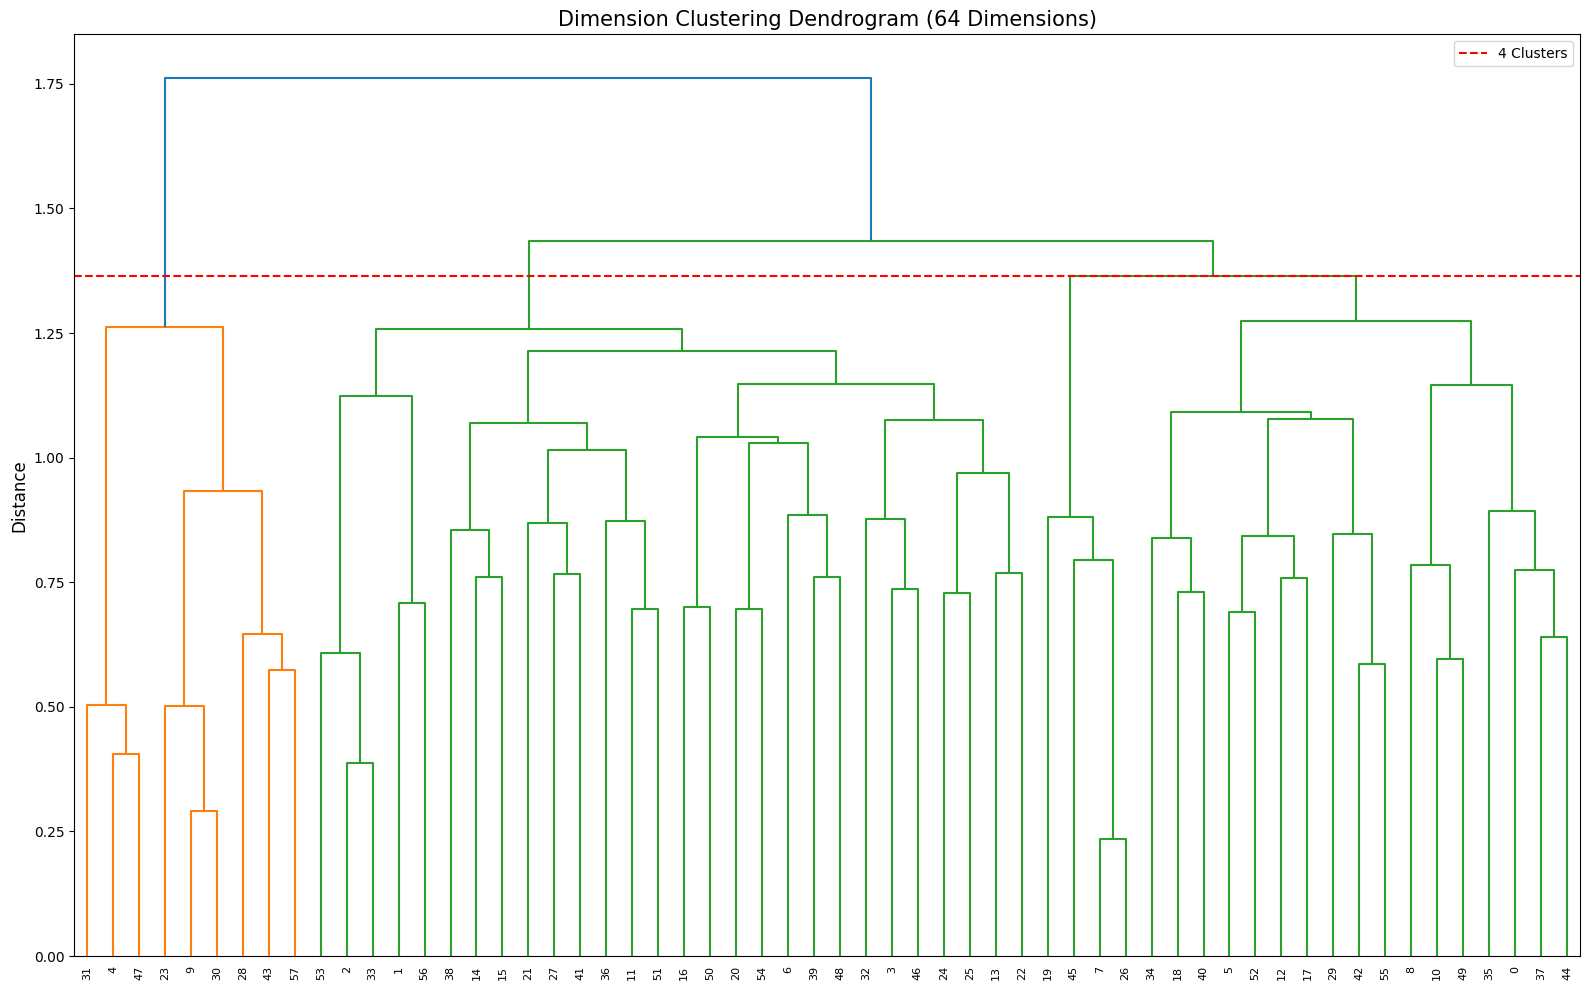


--- 차원별 그룹 할당 결과 ---
그룹 1 (총 9개): [4, 9, 23, 28, 30, 31, 43, 47, 57]
그룹 2 (총 28개): [1, 2, 3, 6, 11, 13, 14, 15, 16, 20, 21, 22, 24, 25, 27, 32, 33, 36, 38, 39, 41, 46, 48, 50, 51, 53, 54, 56]
그룹 3 (총 21개): [0, 5, 7, 8, 10, 12, 17, 18, 19, 26, 29, 34, 35, 37, 40, 42, 44, 45, 49, 52, 55]


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# 데이터 로드
data = torch.load('/home/ubuntu/latent/deep_learning_dataset/decodable_matched_latent.pt', weights_only=True).detach().cpu().numpy()
all_zero_cols =np.where(np.all(data == 0, axis=0))[0]
l =list(all_zero_cols)
non_zero_cols =[i for i in range(64) if i not in l]
data = data[:, non_zero_cols]
print(f"데이터 shape: {data.shape}")
print(f"데이터 type: {type(data)}")

# 차원 간 상관계수 행렬 계산
corr_matrix = np.corrcoef(data.T)  # (64, 64)
print(f"상관계수 행렬 shape: {corr_matrix.shape}")
print(f"NaN 개수: {np.isnan(corr_matrix).sum()}")

# 대칭화 확인
corr_matrix = (corr_matrix + corr_matrix.T) / 2
np.fill_diagonal(corr_matrix, 1.0)

print(f"NaN 처리 후 상관계수 행렬 shape: {corr_matrix.shape}")
print(f"유효한 차원 수: {corr_matrix.shape[0]}")

# 상관계수를 거리로 변환
distance_matrix = 1 - np.abs(corr_matrix)

# 거리 행렬 대칭화 및 검증
distance_matrix = (distance_matrix + distance_matrix.T) / 2
np.fill_diagonal(distance_matrix, 0)

print(f"거리 행렬 shape: {distance_matrix.shape}")
print(f"거리 행렬의 유한값 개수: {np.isfinite(distance_matrix).sum()}")
print(f"거리 행렬의 최소값: {np.min(distance_matrix)}, 최대값: {np.max(distance_matrix)}")

# 계층적 클러스터링
try:
    condensed_dist = squareform(distance_matrix)
    print(f"응축된 거리 벡터 크기: {len(condensed_dist)}")
    linkage_matrix = linkage(condensed_dist, method='ward')
    
    # 덴드로그램 시각화
    plt.figure(figsize=(16, 10))
    dendro = dendrogram(
        linkage_matrix,
        leaf_rotation=90,
        leaf_font_size=8,
        color_threshold=linkage_matrix[-3, 2] + 0.1
    )
    plt.axhline(y=linkage_matrix[-3, 2], color='red', linestyle='--', label='4 Clusters')
    plt.title('Dimension Clustering Dendrogram (64 Dimensions)', fontsize=15)
    plt.ylabel('Distance', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 실제 그룹 할당 결과 출력
    n_clusters = 3
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    print("\n--- 차원별 그룹 할당 결과 ---")
    for i in range(1, n_clusters + 1):
        dims_in_group = np.where(cluster_labels == i)[0]
        print(f"그룹 {i} (총 {len(dims_in_group)}개): {dims_in_group.tolist()}")
        
except Exception as e:
    print(f"에러 발생: {e}")
    import traceback
    traceback.print_exc()